Setup. Should factor into its own file.

In [45]:
from math import pi
from functools import partial
import time

from jax import grad, jit, vmap, jacfwd, jacrev, random
from jax.ops import index_update
import jax.numpy as jnp
from jax.config import config
from jax.scipy.special import gammaln
import numpy.random as np_random
import matplotlib.pyplot as plt
import numpy as np

config.update("jax_enable_x64", True)

from twoPN_simple import amp_2pn, Psi_2pn_ms
from threePN_simple import Amp_35PN, Psi_35PN

MSun = 1.98855e30  # kg
G = 6.67408e-11  # m^3 s^-2 kg^-1
c = 299792458.  # m/s


def hessian(fun):
    return jit(jacfwd(jacrev(fun)))


def match(theta, del_t, del_theta, amp, Psi, fs, Sn):
    # Evaluate all functions over frequency gradient
    amps = amp(fs, theta)
    amp_del = amp(fs, theta + del_theta)
    amp_prods = amps * amp_del
    del_phases = (2.0 * pi * fs * del_t) + (Psi(fs, theta + del_theta) - Psi(fs, theta))
    Sns = Sn(fs)

    # Normalize both waveforms
    norm = jnp.sqrt(4 * jnp.trapz(amps ** 2 / Sns, fs))
    norm_del = jnp.sqrt(4 * jnp.trapz(amp_del ** 2 / Sns, fs))

    # Compute unnormalized match, maximizing over Phi_0 by taking the absolute value
    re_integral = 4.0 * jnp.trapz(amp_prods * jnp.cos(del_phases) / Sns, fs)
    im_integral = 4.0 * jnp.trapz(amp_prods * jnp.sin(del_phases) / Sns, fs)
    match_un = jnp.sqrt(re_integral ** 2 + im_integral ** 2)

    return match_un / (norm * norm_del)


def get_gam(theta, amp, Psi, fs, Sn):
    """
    Metric for t_0 and intrinsic parameters.
    """
    hess_func = lambda delta: match(theta, delta[0], delta[1:], amp, Psi, fs, Sn)
    del_theta = jnp.zeros(theta.size + 1)
    return -1 / 2 * hessian(hess_func)(del_theta)


def get_g(theta, amp, Psi, fs, S):
    """
    Metric for intrinsic parameters.
    """
    gam = get_gam(theta, amp, Psi, fs, S)
    # Maximize over Δt₀
    return gam[1:, 1:] - jnp.outer(gam[0, 1:], gam[0, 1:]) / gam[0, 0]


@partial(jit, static_argnums=(1, 2, 4))
def get_g_jit(theta, amp, Psi, fs, S):
    return get_g(theta, amp, Psi, fs, S)


def Sn_func(f):
    fs = 40  # Hz
    f_theta = 150  # Hz
    x = f / f_theta
    normalization = 1e-46
    return jnp.where(
        f > fs,
        normalization
        * 9
        * ((4.49 * x) ** (-56) + 0.16 * x ** (-4.52) + 0.52 + 0.32 * x ** 2),
        jnp.inf,
    )

In [2]:
# Basic test
f = jnp.geomspace(10, 500, 10000)
print(
    "Match:",
    match(
        jnp.array([3, 1 / 4]),
        0.0,
        jnp.array([0.0, 0.0]),
        Amp_35PN,
        Psi_35PN,
        f,
        Sn_func,
    ),
    "\n",
)
print(
    "Metric: ", get_g_jit(jnp.array([3, 1 / 4]), Amp_35PN, Psi_35PN, f, Sn_func), "\n"
)

# Benchmark
t0 = time.time()
N = 200
Ms = np_random.uniform(1, 3, N)
etas = np_random.uniform(0.1, 0.25, N)
for i in range(N):
    # See https://jax.readthedocs.io/en/latest/async_dispatch.html for explanation
    # of `block_until_ready`.
    get_g_jit(
        jnp.array([Ms[i], etas[i]]), Amp_35PN, Psi_35PN, f, Sn_func
    ).block_until_ready()
t1 = time.time()

total = t1 - t0
print(f"{total / N} s/it")

Match: 0.9999999999999998 

Metric:  [[  23118.46030924  161944.17143052]
 [ 161944.17143052 1134481.31429615]] 

0.005099925994873047 s/it


## Number of templates

Compute number of templates with eq. 15 from https://arxiv.org/pdf/0809.5223.pdf

In [ ]:
# TODO: jax-ify and jit the whole calculation
def get_x(thetas, Amp, Psi, f, Sn_func):
    return 0.5 * jnp.log10(jnp.linalg.det(get_g_jit(thetas, Amp, Psi, f, Sn_func)))


def V(n):
    return pi ** (n / 2) / jnp.exp(gammaln((n / 2) + 1))


def gen_samples_from_ranges(p1range, p2range, N):
    p1s = np_random.uniform(p1range[0], p1range[1], N)
    p2s = np_random.uniform(p2range[0], p2range[1], N)
    samples_thetas = jnp.vstack([p1s, p2s]).T
    return samples_thetas


def Vol(p1range, p2range, N, Amp, Psi, f, Sn_func):
    thetas = gen_samples_from_ranges(p1range, p2range, N)
    x = vmap(lambda theta: get_x(theta, Amp, Psi, f, Sn_func))(thetas)
    mean_x = jnp.mean(x)
    x_s = x - mean_x
    tot = (1 / N) * sum(10 ** x_s)
    return 10 ** (mean_x + jnp.log10(tot))


def N_templates(p1range, p2range, N, eta, m, Amp, Psi, f, Sn_func, n=2):
    Vs = Vol(p1range, p2range, N, Amp, Psi, f, Sn_func)
    Vn = V(n)
    Norm = ((p1range[1] - p1range[0]) * (p2range[1] - p2range[0])) / 2
    return (1 / Vn) * jnp.log(1 / (1 - eta)) * (m ** (-n / 2)) * Vs * Norm

In [ ]:
m_star = 1 - 0.95
r1_new = jnp.array([1, 3]) * MSun
r2_new = jnp.array([1, 3]) * MSun
N_test = 1000
eta = 0.9999

f = jnp.geomspace(10, 500, 10000)
thetas_test = jnp.array([3.0, 2.0]) * MSun
print(N_templates(r1_new, r2_new, N_test, eta, m_star, amp_2pn, Psi_2pn_ms, f, Sn_func))

## Differential geometry

In [3]:
from diffgeom import *

3.5PN metric

In [4]:
def get_M_eta(m_1, m_2):
    M = m_1 + m_2
    return jnp.array([M, m_1 * m_2 / M**2])


f = jnp.geomspace(10, 500, 10000)
theta = jnp.array([3, 1 / 4])

get_g_gw = lambda theta: get_g(theta, Amp_35PN, Psi_35PN, f, Sn_func)
get_christoffel2_gw = jit(lambda theta: get_christoffel2(theta, get_g_gw))
get_ricci_scalar_gw = jit(lambda theta: get_ricci_scalar(theta, get_g_gw))

In [57]:
%timeit get_christoffel2_gw(get_M_eta(1.5, 1.1))

26.1 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
%timeit get_christoffel2_gw(get_M_eta(np_random.rand() * 5, np_random.rand() * 5))

25.5 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%timeit get_ricci_scalar_gw(get_M_eta(np_random.rand() * 5, np_random.rand() * 5))

195 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
def get_M_eta(m_1, m_2):
    M = m_1 + m_2
    return jnp.array([M, m_1 * m_2 / M**2])

In [42]:
m_1s = jnp.linspace(1, 3, 50)
m_2s = jnp.linspace(1, 3, 48)
theta_1_mg, theta_2_mg = get_M_eta(*jnp.meshgrid(m_1s, m_2s))
Rs_mg = np.full_like(theta_1_mg, jnp.nan)

for i in range(len(m_2s)):
    for j in range(len(m_1s)):
        if m_2s[i] <= m_1s[j]:
            theta = jnp.array([theta_1_mg[i, j], theta_2_mg[i, j]])
            Rs_mg[i, j] = get_ricci_scalar_gw(theta)

Text(0.5, 1.0, 'Scalar curvature')

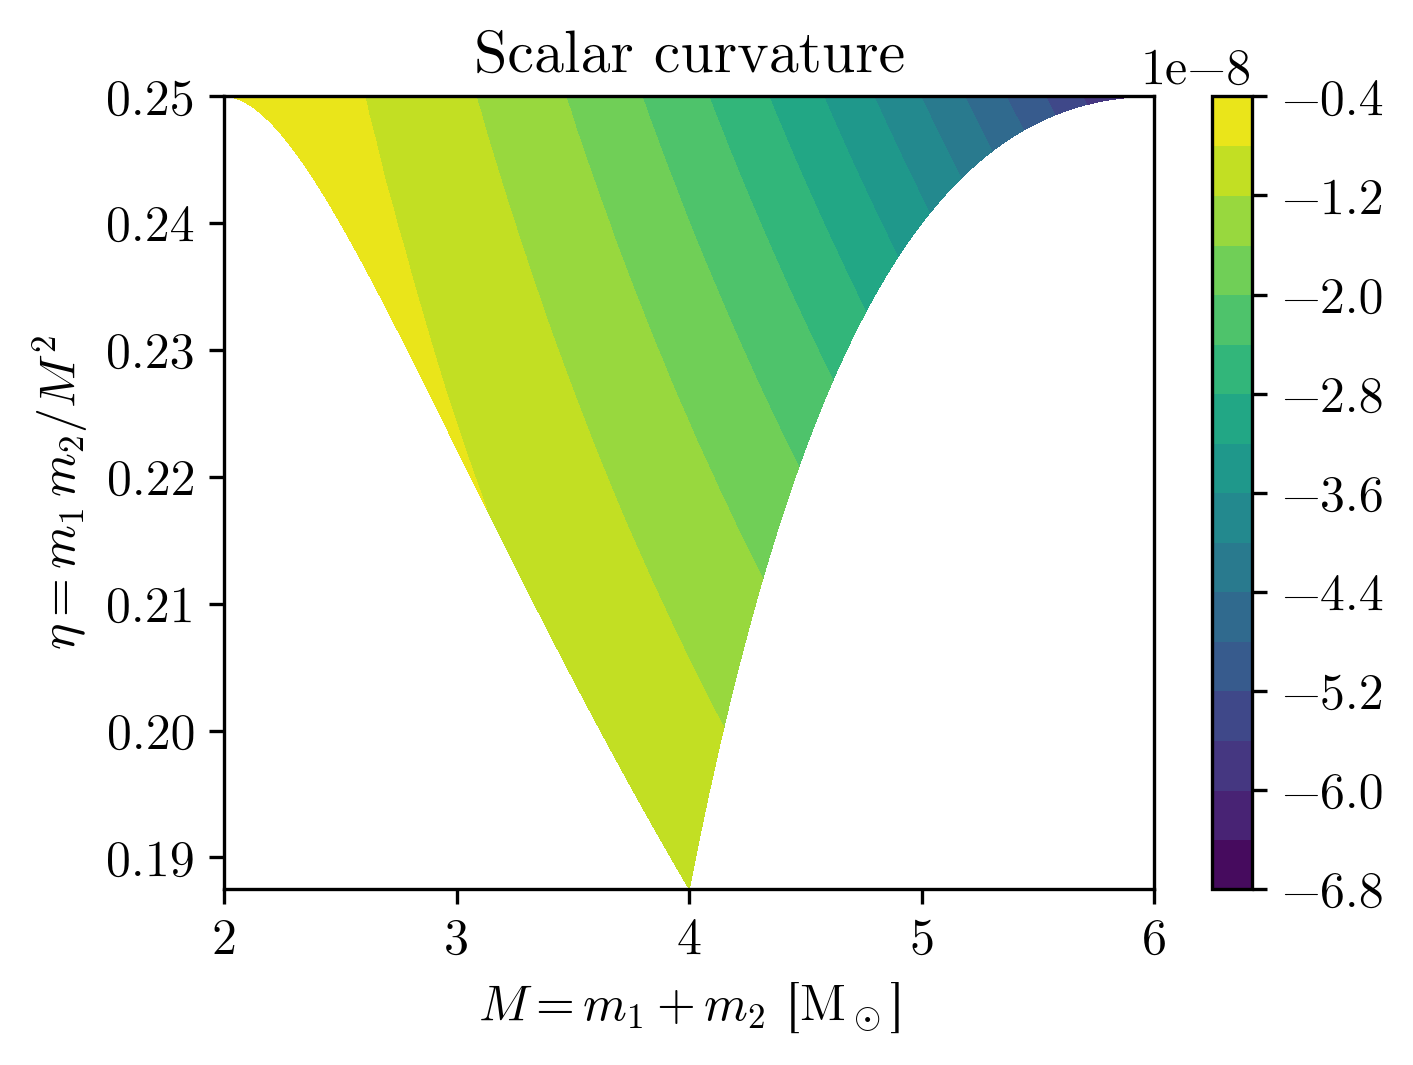

In [44]:
plt.contourf(theta_1_mg, theta_2_mg, Rs_mg, levels=15)
plt.colorbar()
plt.xlabel(r"$M = m_1 + m_2$ [M$_\odot$]")
plt.ylabel(r"$\eta = m_1 \, m_2 / M^2$")
plt.title(f"Scalar curvature, 3.5PN $(M, \eta)$ metric")

1PN $\tau$ metric from Owen 1995

In [46]:
def Sn_LIGO(f, f_0=200, f_s=40, S_0=1) -> jnp.ndarray:
    return jnp.where(
        f > f_s, 1 / 5 * S_0 * ((f / f_0) ** (-4) + 2 * (1 + (f / f_0) ** 2)), jnp.inf
    )


def get_M_eta(m_1, m_2) -> jnp.ndarray:
    M = m_1 + m_2
    return jnp.array([M, m_1 * m_2 / M ** 2])


def get_taus(M, eta, f_0=200) -> jnp.ndarray:
    tau_1 = (
        5 / 256 * eta ** (-1) * (G * M) ** (-5 / 3) * (pi * f_0) ** (-8 / 3) * c ** 5
    )  # s
    tau_2 = (
        5
        / 192
        * (G * eta * M) ** (-1)
        * (743 / 336 + 11 / 4 * eta)
        * (pi * f_0) ** (-2)
        * c ** 3
    )  # s
    return jnp.array([tau_1, tau_2])


def Psi_1pn(f, taus, f_0=200) -> jnp.ndarray:
    return (
        6 / 5 * pi * f_0 * (f / f) ** (-5 / 3) * taus[0]
        + 2 * pi * f_0 / (f / f_0) * taus[1]
    )


def amp_1pn(f, taus, f_0=200) -> jnp.ndarray:
    return 1 / f ** (7 / 6)

In [48]:
fs = jnp.geomspace(10, 500, 10000)
theta = jnp.array([3, 1 / 4])

get_g_1pn = lambda taus: get_g(taus, amp_1pn, Psi_1pn, fs, Sn_LIGO)
get_christoffel2_1pn = jit(lambda taus: get_christoffel2(taus, get_g_1pn))
get_ricci_scalar_1pn = jit(lambda taus: get_ricci_scalar(taus, get_g_1pn))

In [60]:
%timeit get_christoffel2_1pn(get_taus(*get_M_eta(np_random.rand() * 5, np_random.rand() * 5)))

3.92 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%timeit get_ricci_scalar_1pn(get_taus(*get_M_eta(np_random.rand() * 5, np_random.rand() * 5)))

11.5 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
m_1s = jnp.linspace(1, 3, 50)
m_2s = jnp.linspace(1, 3, 48)
tau_1_mg, tau_2_mg = get_taus(*get_M_eta(*jnp.meshgrid(m_1s, m_2s)))
Rs_mg = np.full_like(tau_1_mg, jnp.nan)

for i in range(len(m_2s)):
    for j in range(len(m_1s)):
        if m_2s[i] <= m_1s[j]:
            tau = jnp.array([tau_1_mg[i, j], tau_2_mg[i, j]])
            Rs_mg[i, j] = get_ricci_scalar_gw(tau)

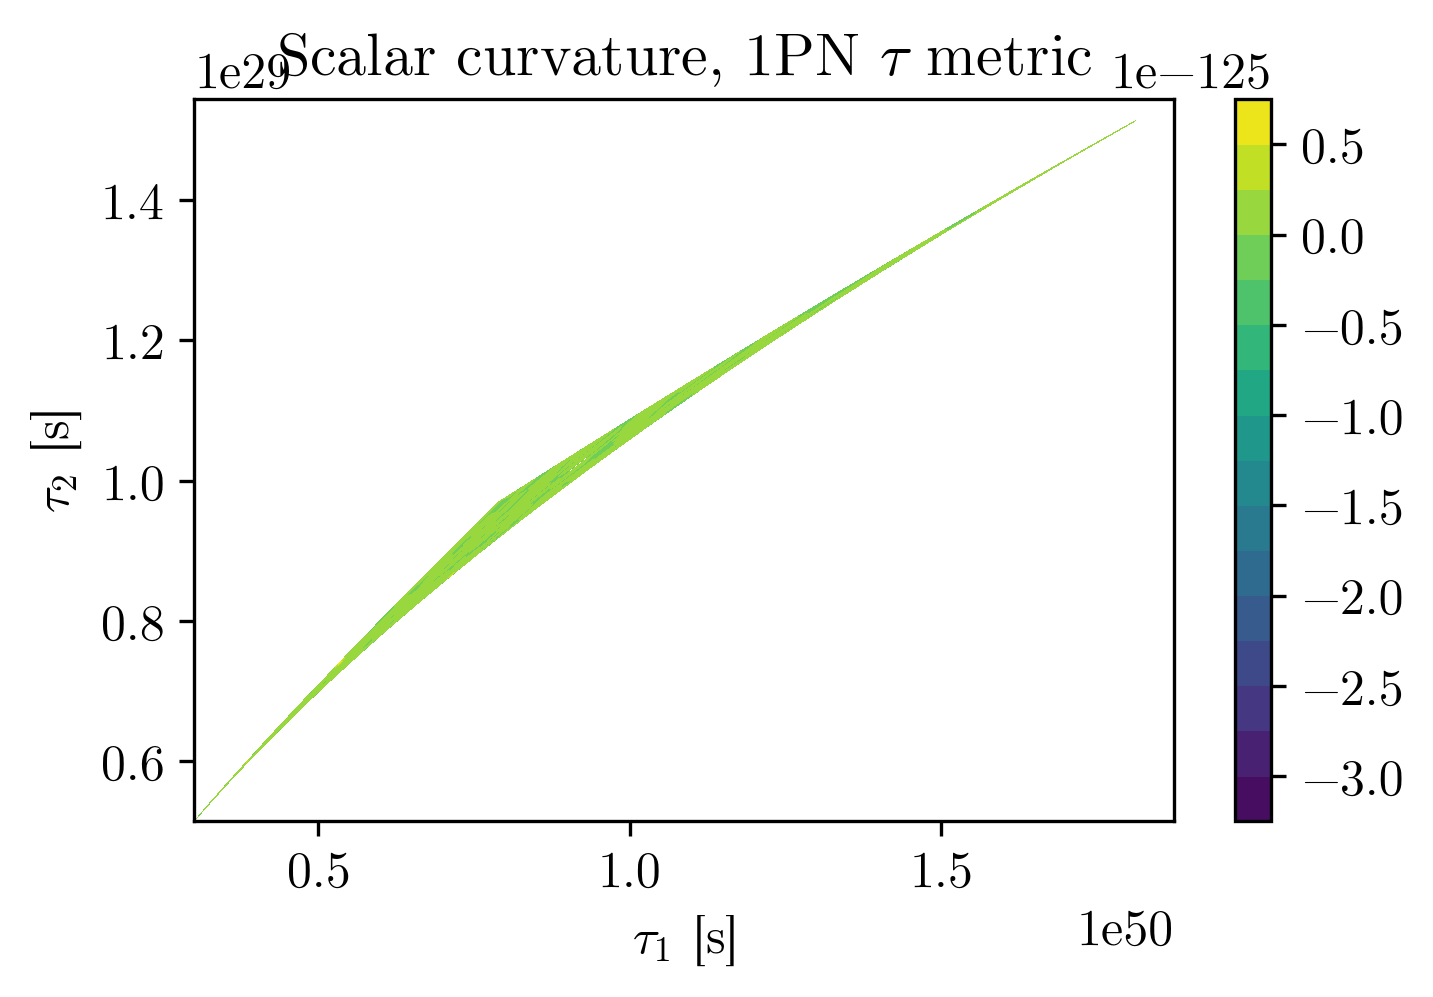

In [67]:
plt.contourf(tau_1_mg, tau_2_mg, Rs_mg, levels=15)
plt.colorbar()
plt.xlabel(r"$\tau_1$ [s]")
plt.ylabel(r"$\tau_2$ [s]")
plt.title(r"Scalar curvature, 1PN $\tau$ metric")
plt.tight_layout()